In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import os,sys
sys.path.append('..')
from utils.utils import set_seed
import argparse
import seaborn as sns
import random
from utils.utils import  G
from matplotlib.ticker import ScalarFormatter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib
from utils.utils import Autoencoder
torch.set_default_dtype(torch.float32)
from scipy.integrate import solve_ivp
set_seed(42)
np.set_printoptions(precision=3, suppress=False, formatter={'float': '{:0.2e}'.format})
Fontsize = 16

In [2]:
device = torch.device('cuda:2')
test_path = './processed_data/test'
hidden_dim = 4
AE = torch.load('./checkpoints/AE_dim_4_2024_04_08_11:13:43/final.pt', map_location=device)
params = torch.load('./checkpoints/AE_dim_4_2024_04_08_11:13:43/params.pt', map_location=device)
Z_mean = params['Z_mean']
Z_std = params['Z_std']
target_mean = params['target_mean']
target_std = params['target_std']

In [3]:
inter_csv_path = 'results_process/result.csv'

inter_csv = pd.read_csv(inter_csv_path)
inter_dict = {}

for i in range(len(inter_csv)):
    key = inter_csv.iloc[i,0].split('/')[-1]
    val = inter_csv.iloc[i,1]
    inter_dict[key] = val

In [4]:
n_dict = {'20': [3000, 7500, 15000, 30000, 60000, 120000],
            '25': [2400, 6000, 12000, 24000, 48000, 96000],
            '50': [1200, 3000, 6000, 12000, 24000, 48000],
            '75': [800, 2000, 4000, 8000, 16000, 32000],
            '100':[600, 1500, 3000, 6000, 12000, 24000]}

In [5]:
N = 100
seed_list = [1, 2, 3]

inter_mse_lx = {}
for key, n_list in n_dict.items():
    d = int(key)
    for n in n_list:
        path = f'G_N_{N}_n_{int(n * d / 100)}_d_{d}'
        inter_mse_lx[path] = []
        for seed in seed_list:
            key_seed =  f'G_N_{N}_n_{n}_seed_{seed}_d_{d}'
            if key_seed in inter_dict.keys():
                inter_mse_lx[path].append(inter_dict[key_seed])

inter_mse_lz = {}
for n in n_dict['100']:
    key = f'G_N_{N}_n_{n}'
    inter_mse_lz[key] = []
    for seed in seed_list:
        key_seed =  f'G_N_{N}_n_{n}_seed_{seed}'
        if key_seed in inter_dict.keys():
                inter_mse_lz[key].append(inter_dict[key_seed])

In [6]:
inter_mse_lx['G_N_100_n_1500_d_100'] = [0.004379852, 0.005023784] # pop the value that is out of distribution 

In [7]:
c_list = ['tab:blue', 'tab:orange','tab:olive','tab:red','tab:purple','k']

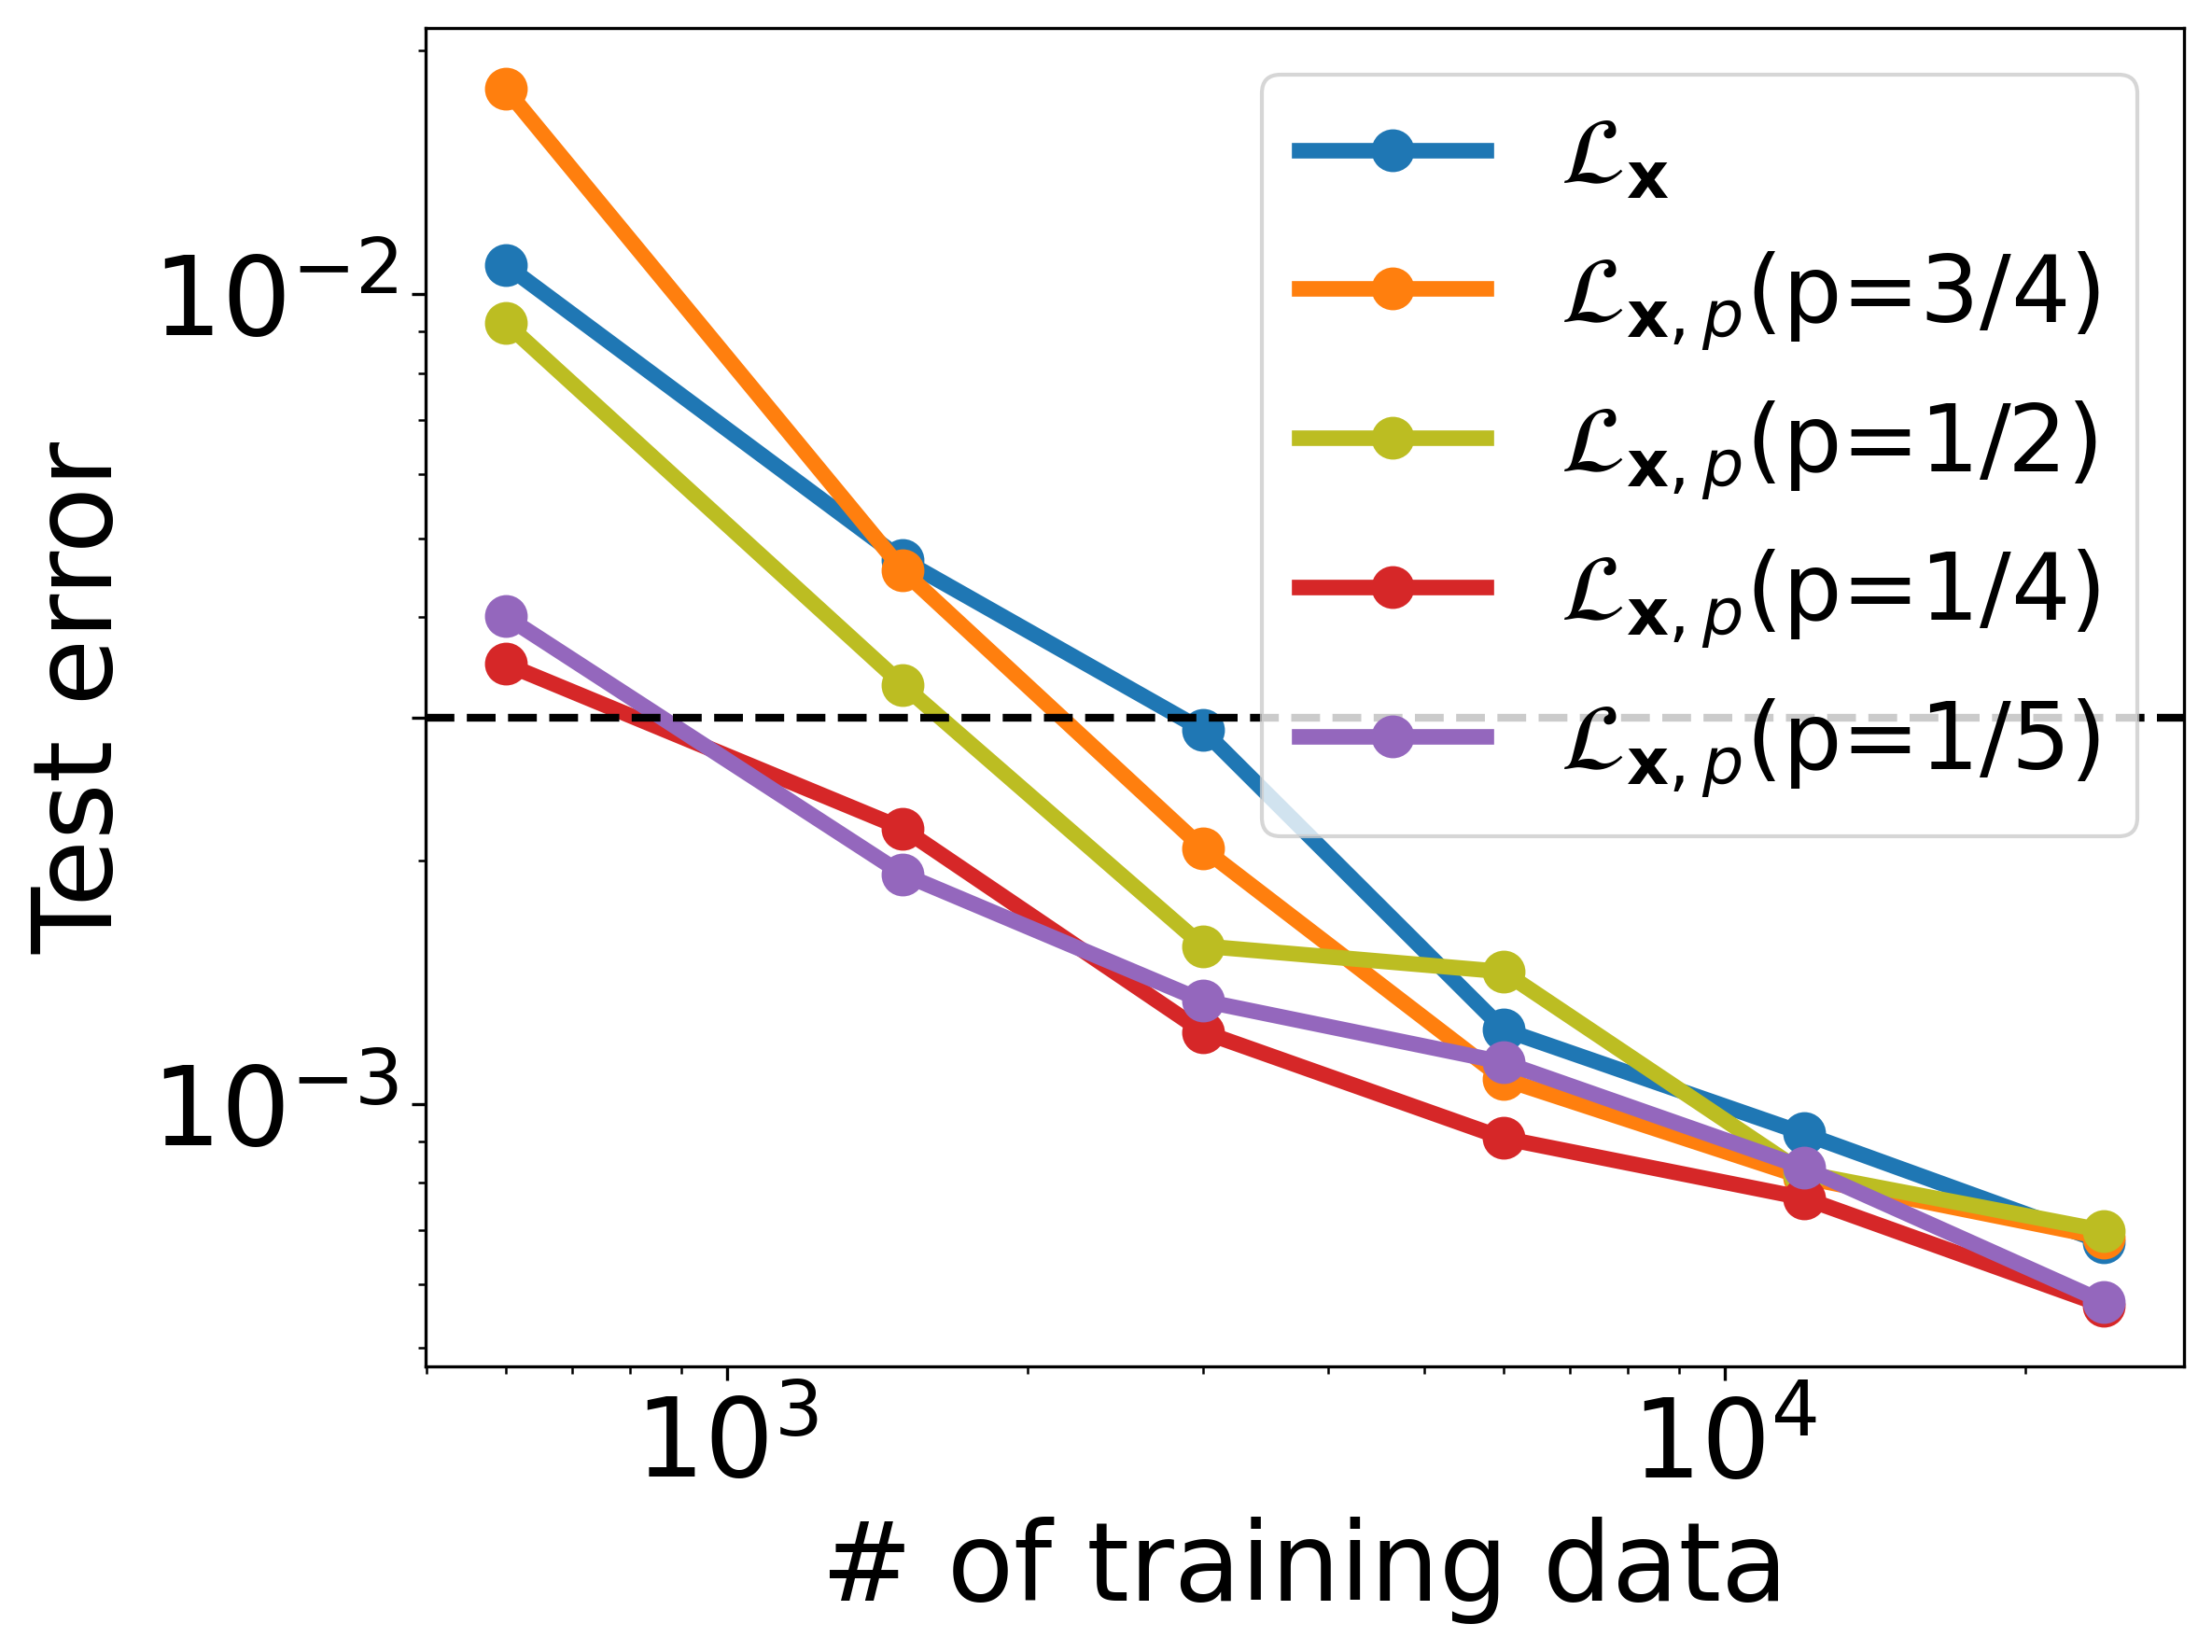

In [8]:
# sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(8,6),dpi=300)
axes = fig.add_subplot(1,1,1)
n = np.array(n_dict['100'])
la = []
d_list = [100, 75, 50, 25, 20]
ps = ['1', '3/4', '1/2', '1/4', '1/5']

formatter = ScalarFormatter(useMathText=True)  # Enable math text for LaTeX style
formatter.set_powerlimits((4,4))  # Use scientific notation everywhere
axes.xaxis.set_major_formatter(formatter)  # Apply formatter to the x-axis

formatter = ScalarFormatter(useMathText=True)  # Enable math text for LaTeX style
formatter.set_powerlimits((0,0))  # Use scientific notation everywhere
axes.yaxis.set_major_formatter(formatter)  # Apply formatter to the x-axis


for idx,d in enumerate(d_list):
    mean = []
    std = []
    for num in n_list:
        key = f'G_N_{N}_n_{num}_d_{d}'
        mean.append(np.mean(inter_mse_lx[key]))
        std.append(np.std(inter_mse_lx[key],ddof=0))
    mean = np.array(mean)
    std = np.array(std)
    la.append(mean)
    label = '$\mathcal{L}_{\mathbf{x},p}$'+f'(p={ps[idx]})' if idx > 0 else '$\mathcal{L}_{\mathbf{x}}$'
    axes.plot(n, mean, 'o-',label=label,c=c_list[idx],linewidth=4, markersize=10)
    
axes.axhline(y=3e-3, color='k', linestyle='--', linewidth=2)

axes.set_yscale('log')
axes.set_xscale('log')
axes.legend(loc='upper right', fontsize=24)
axes.set_xlabel('# of training data',fontsize=28)
axes.set_ylabel('Test error',fontsize=28)
plt.xticks(fontsize=28)
plt.yticks(ticks=[1e-3, 3e-3, 1e-2],fontsize=28)
plt.tight_layout()
plt.savefig('img/data_efficiency.pdf')
plt.show() 

In [9]:
la = np.array(la)
la.T

array([[1.09e-02, 1.79e-02, 9.22e-03, 3.50e-03, 4.00e-03],
       [4.70e-03, 4.56e-03, 3.30e-03, 2.19e-03, 1.92e-03],
       [2.90e-03, 2.07e-03, 1.57e-03, 1.23e-03, 1.34e-03],
       [1.24e-03, 1.07e-03, 1.46e-03, 9.08e-04, 1.13e-03],
       [9.20e-04, 8.13e-04, 8.23e-04, 7.66e-04, 8.36e-04],
       [6.76e-04, 6.85e-04, 6.98e-04, 5.64e-04, 5.70e-04]])

In [10]:
test_data_path = './processed_data/test/plot.pt'
X_dict = torch.load(test_data_path, map_location=device)
X = X_dict['X'] # [3000, 2, 50]
X = X.reshape(3000, 100 ,2, 50)
moment = torch.mean(X, -1) # [3000, 50, 2]
print(X.shape)
z_NN = AE.encoder(X.flatten(2,3)) # [3000, 50, 2]
Z = torch.cat([moment, z_NN], -1).detach().cpu().numpy() # [3000, 50, 4]

dt = 0.5
t_eval = np.arange(60) * dt
print('Z shape:', Z.shape) # (3000, 50, 6)
ylabels = ['u_mean', 'v_mean', 'reduction dim 1', 'reduction dim 2']

torch.Size([3000, 100, 2, 50])
Z shape: (3000, 100, 4)


In [11]:
def RK4_func(t, y, g, hidden_dim=4):
    y = y.reshape(-1, hidden_dim) 
    y = (y - Z_mean) / Z_std
    f = g(y)
    f = f * target_std + target_mean
    f = f

    return f 

def rk4(f, t,y0, g):
    n = len(t)
    y = [y0] * n # [[100, 4] * 3000]
    dt = t[1] - t[0]  # Assumes uniform spacing
    for i in tqdm(range(n - 1)):
        k1 = dt * f(t[i], y[i], g)
        k2 = dt * f(t[i] + dt / 2, y[i] + k1 / 2, g)
        k3 = dt * f(t[i] + dt / 2, y[i] + k2 / 2, g)
        k4 = dt * f(t[i] + dt, y[i] + k3, g)
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    y = torch.stack(y).detach().cpu().numpy()
    return y

In [12]:
g_lz_path = './checkpoints_100_lz_saved/G_N_100_n_24000_seed_1'
g_lx_path = './checkpoints_100_lx_saved/G_N_100_n_24000_seed_1_d_100'
g_p20_path = './checkpoints_100_lx_saved/G_N_100_n_120000_seed_1_d_20'
ckpt_name = 'convergence_final.pt'


g_lz = torch.load(os.path.join(g_lz_path, ckpt_name), map_location=device)
g_lx = torch.load(os.path.join(g_lx_path, ckpt_name), map_location=device)
g_p_20 = torch.load(os.path.join(g_p20_path, ckpt_name), map_location=device)

In [13]:
Z_0 = Z[0]
Z_0 = torch.tensor(Z_0, device=device, dtype=torch.float32)
Z_pred_lz = rk4(RK4_func, t_eval, Z_0, g_lz) # [3000, 100, 4]
Z_pred_lx = rk4(RK4_func, t_eval, Z_0, g_lx) # [3000, 100, 4]
Z_pred_p_20 = rk4(RK4_func, t_eval, Z_0, g_p_20) # [3000, 100, 4]

100%|██████████| 59/59 [00:00<00:00, 104.70it/s]


In [14]:
Z = Z[::50]

In [15]:
Z_l2 = np.sqrt(np.sum(np.square(Z)[:,:,:2], -1)) # [3000, 100]

error_lz = np.sqrt(np.sum(np.square(Z_pred_lz - Z)[:,:,:2], -1)) # [3000, 121]
error_lz = error_lz.sum(0) / Z_l2.sum(0) 
idx = np.where(error_lz<1)[0]
print('N fails lz:', 100 - idx.shape[0])
# error_lz = np.mean(error_lz[idx])

error_lx = np.sqrt(np.sum(np.square(Z_pred_lx - Z)[:,:,:2], -1)) # [3000, 121]
error_lx = error_lx.sum(0) / Z_l2.sum(0) 
idx = np.where(error_lx<1)[0]
print('N fails lx:', 100 - idx.shape[0])
# error_lx = np.mean(error_lx[idx])

error_p_20 = np.sqrt(np.sum(np.square(Z_pred_p_20 - Z)[:,:,:2], -1)) # [3000, 121]
error_p_20 = error_p_20.sum(0) / Z_l2.sum(0) 
idx = np.where(error_p_20<1)[0]
print('N fails l_p_20:', 100 - idx.shape[0])
# error_p_20 = np.mean(error_p_20[idx])

print('error_lz:', error_lz)
print('error_lx:', error_lx)
print('error_p_20:', error_p_20)

N fails lz: 0
N fails lx: 0
N fails l_p_20: 0
error_lz: [9.08e-05 2.58e-04 4.47e-04 6.32e-04 8.23e-04 1.09e-03 1.55e-03 2.31e-03
 3.44e-03 4.96e-03 1.84e-04 2.98e-04 4.12e-04 4.35e-04 4.58e-04 5.79e-04
 5.75e-04 6.09e-04 8.43e-04 1.83e-03 4.18e-04 4.81e-04 5.98e-04 4.66e-04
 4.11e-04 1.10e-03 1.58e-03 1.59e-03 1.15e-03 1.09e-03 4.59e-04 4.60e-04
 6.52e-04 6.00e-04 2.24e-04 1.07e-03 1.79e-03 1.99e-03 1.67e-03 1.36e-03
 3.48e-04 3.20e-04 5.41e-04 5.68e-04 1.75e-04 9.51e-04 1.56e-03 1.66e-03
 1.29e-03 1.16e-03 2.43e-04 2.26e-04 4.29e-04 4.09e-04 2.66e-04 8.80e-04
 1.21e-03 1.06e-03 6.16e-04 9.72e-04 4.92e-04 2.39e-04 3.28e-04 2.46e-04
 3.27e-04 7.33e-04 8.31e-04 5.47e-04 4.01e-04 1.31e-03 4.54e-04 2.25e-04
 2.88e-04 2.52e-04 3.18e-04 5.13e-04 5.06e-04 2.99e-04 4.47e-04 1.38e-03
 3.62e-04 3.52e-04 4.15e-04 4.05e-04 3.46e-04 3.74e-04 3.02e-04 2.77e-04
 5.10e-04 1.13e-03 5.13e-04 6.57e-04 7.10e-04 7.36e-04 6.46e-04 4.54e-04
 3.52e-04 7.83e-04 1.38e-03 1.64e-03]
error_lx: [2.27e-04 4.91e-04 7

In [17]:


error_lz = np.sqrt(np.sum(np.square(Z_pred_lz - Z)[:,:,:2], -1))
error_lx = np.sqrt(np.sum(np.square(Z_pred_lx - Z)[:,:,:2], -1)) 
error_lp_20 = np.sqrt(np.sum(np.square(Z_pred_p_20 - Z)[:,:,:2], -1)) 


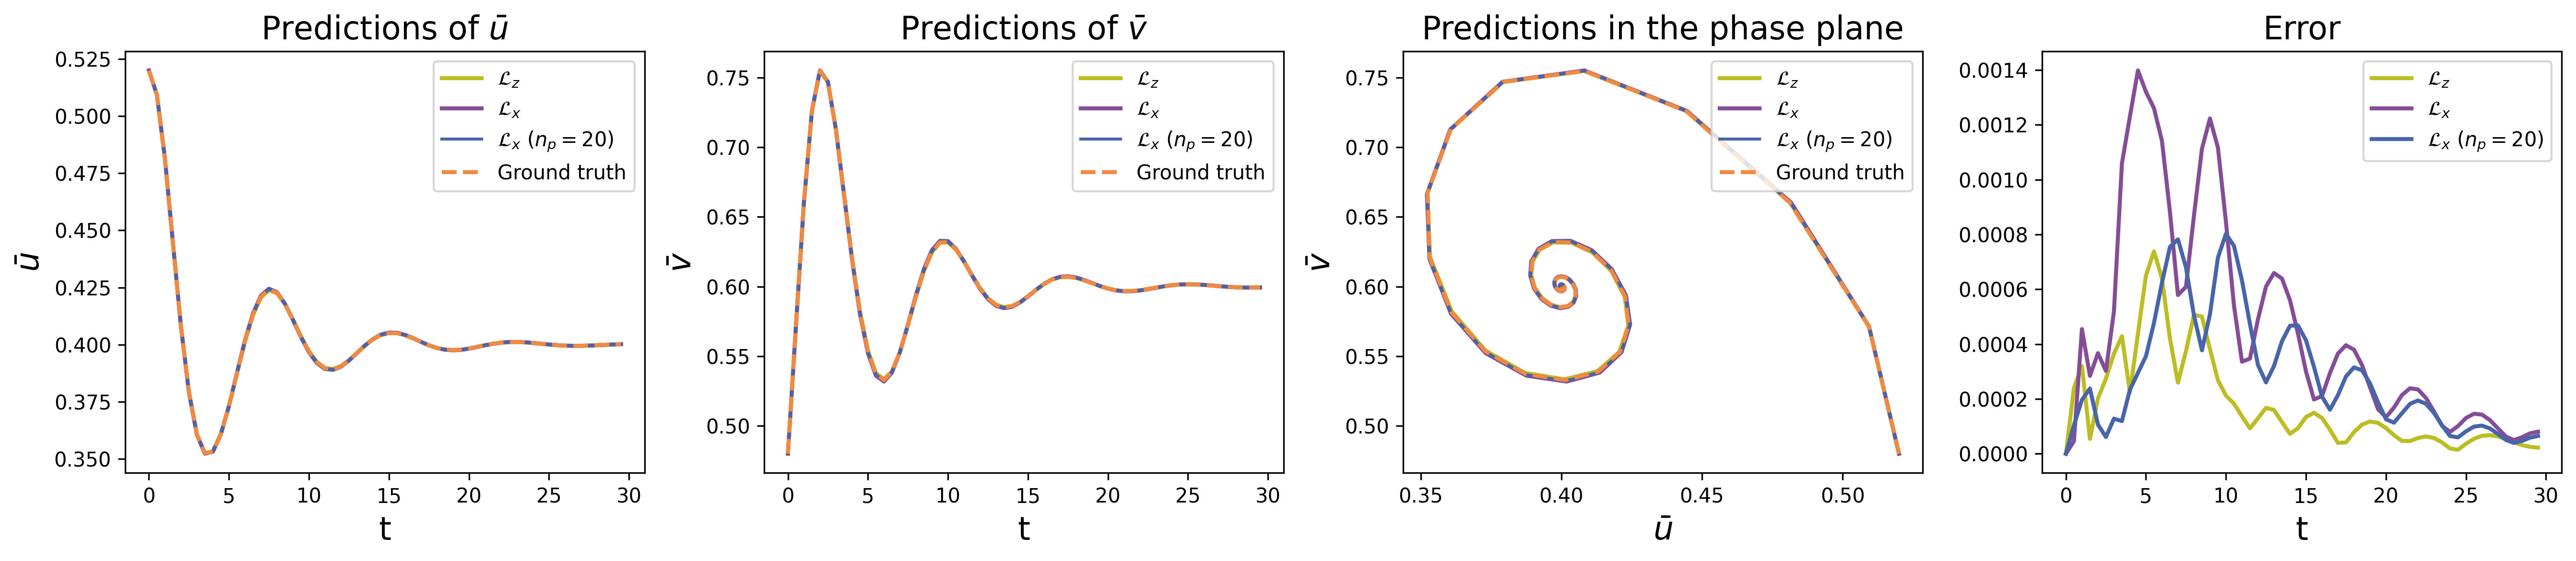

In [18]:
DPI = 300
idx = 50 # a= 0.02 b=0.52
fig = plt.figure(figsize=(18,4),dpi=DPI)
# t = 0.01 * np.arange(3000)
t = t_eval
axes = fig.add_subplot(1,4,1)
axes.plot(t, Z_pred_lz[:, idx, 0], 'tab:olive',label='$\mathcal{L}_z$',linewidth=2)
axes.plot(t, Z_pred_lx[:, idx, 0], '#854C98',label='$\mathcal{L}_x$',linewidth=2)
axes.plot(t, Z_pred_p_20[:, idx, 0],'#4865A9',label='$\mathcal{L}_x \ (n_p=20)$')
axes.plot(t, Z[:, idx, 0],c='#EF8A43',linestyle='--',label='Ground truth',linewidth=2)
axes.set_xlabel('t',fontsize=Fontsize)
axes.set_ylabel('$\\bar{u}$',fontsize=Fontsize)
axes.set_title('Predictions of $\\bar{u}$',fontsize=Fontsize)
axes.legend(loc='upper right')

axes = fig.add_subplot(1,4,2)
axes.plot(t, Z_pred_lz[:, idx, 1], 'tab:olive',label='$\mathcal{L}_z$',linewidth=2)
axes.plot(t, Z_pred_lx[:, idx, 1], '#854C98',label='$\mathcal{L}_x$',linewidth=2)
axes.plot(t, Z_pred_p_20[:, idx, 1],'#4865A9',label='$\mathcal{L}_x \ (n_p=20)$')
axes.plot(t, Z[:, idx, 1],c='#EF8A43',linestyle='--',label='Ground truth',linewidth=2)
axes.set_xlabel('t',fontsize=Fontsize)
axes.set_ylabel('$\\bar{v}$',fontsize=Fontsize)
axes.set_title('Predictions of $\\bar{v}$',fontsize=Fontsize)
axes.legend(loc='upper right')


axes = fig.add_subplot(1,4,3)
axes.plot(Z_pred_lz[:, idx, 0], Z_pred_lz[:, idx, 1], 'tab:olive',label='$\mathcal{L}_z$',linewidth=2)
axes.plot(Z_pred_lx[:, idx, 0], Z_pred_lx[:, idx, 1], '#854C98',label='$\mathcal{L}_x$',linewidth=2)
axes.plot(Z_pred_p_20[:, idx, 0], Z_pred_p_20[:, idx, 1],'#4865A9',label='$\mathcal{L}_x \ (n_p=20)$')
axes.plot(Z[:, idx, 0], Z[:, idx, 1],c='#EF8A43',linestyle='--',label='Ground truth',linewidth=2)
axes.set_xticks([0.35, 0.40, 0.45, 0.50])
axes.set_ylabel('$\\bar{v}$',fontsize=Fontsize)
axes.set_xlabel('$\\bar{u}$',fontsize=Fontsize)
axes.set_title('Predictions in the phase plane',fontsize=Fontsize)
axes.legend(loc='upper right')

axes = fig.add_subplot(1,4,4)
axes.plot(t, error_lz[:, idx], 'tab:olive',label='$\mathcal{L}_z$',linewidth=2)
axes.plot(t, error_lx[:, idx],'#854C98', label='$\mathcal{L}_x$',linewidth=2)
axes.plot(t, error_lp_20[:, idx],'#4865A9',label='$\mathcal{L}_x \ (n_p=20)$',linewidth=2)
axes.set_xlabel('t',fontsize=Fontsize)
axes.set_title('Error',fontsize=Fontsize)
axes.legend(loc='upper right')


plt.tight_layout() 
plt.savefig('img/predator_prey_tra_0.5.pdf')
plt.show()


In [19]:
import numpy as np
a_list = np.linspace(0., 0.2, 11)[1:]
b_list = np.linspace(0.4, 0.6, 11)[1:]
a_list, b_list = np.meshgrid(a_list,b_list)
a_list = a_list.ravel()
b_list = b_list.ravel()
print(a_list[50])
print(b_list[50])

0.02
0.52


In [ ]:
data = torch.load('./raw_data/plot.pt')
X = data['u'][:, 75]
print(X.shape)

torch.Size([3000, 2, 50])


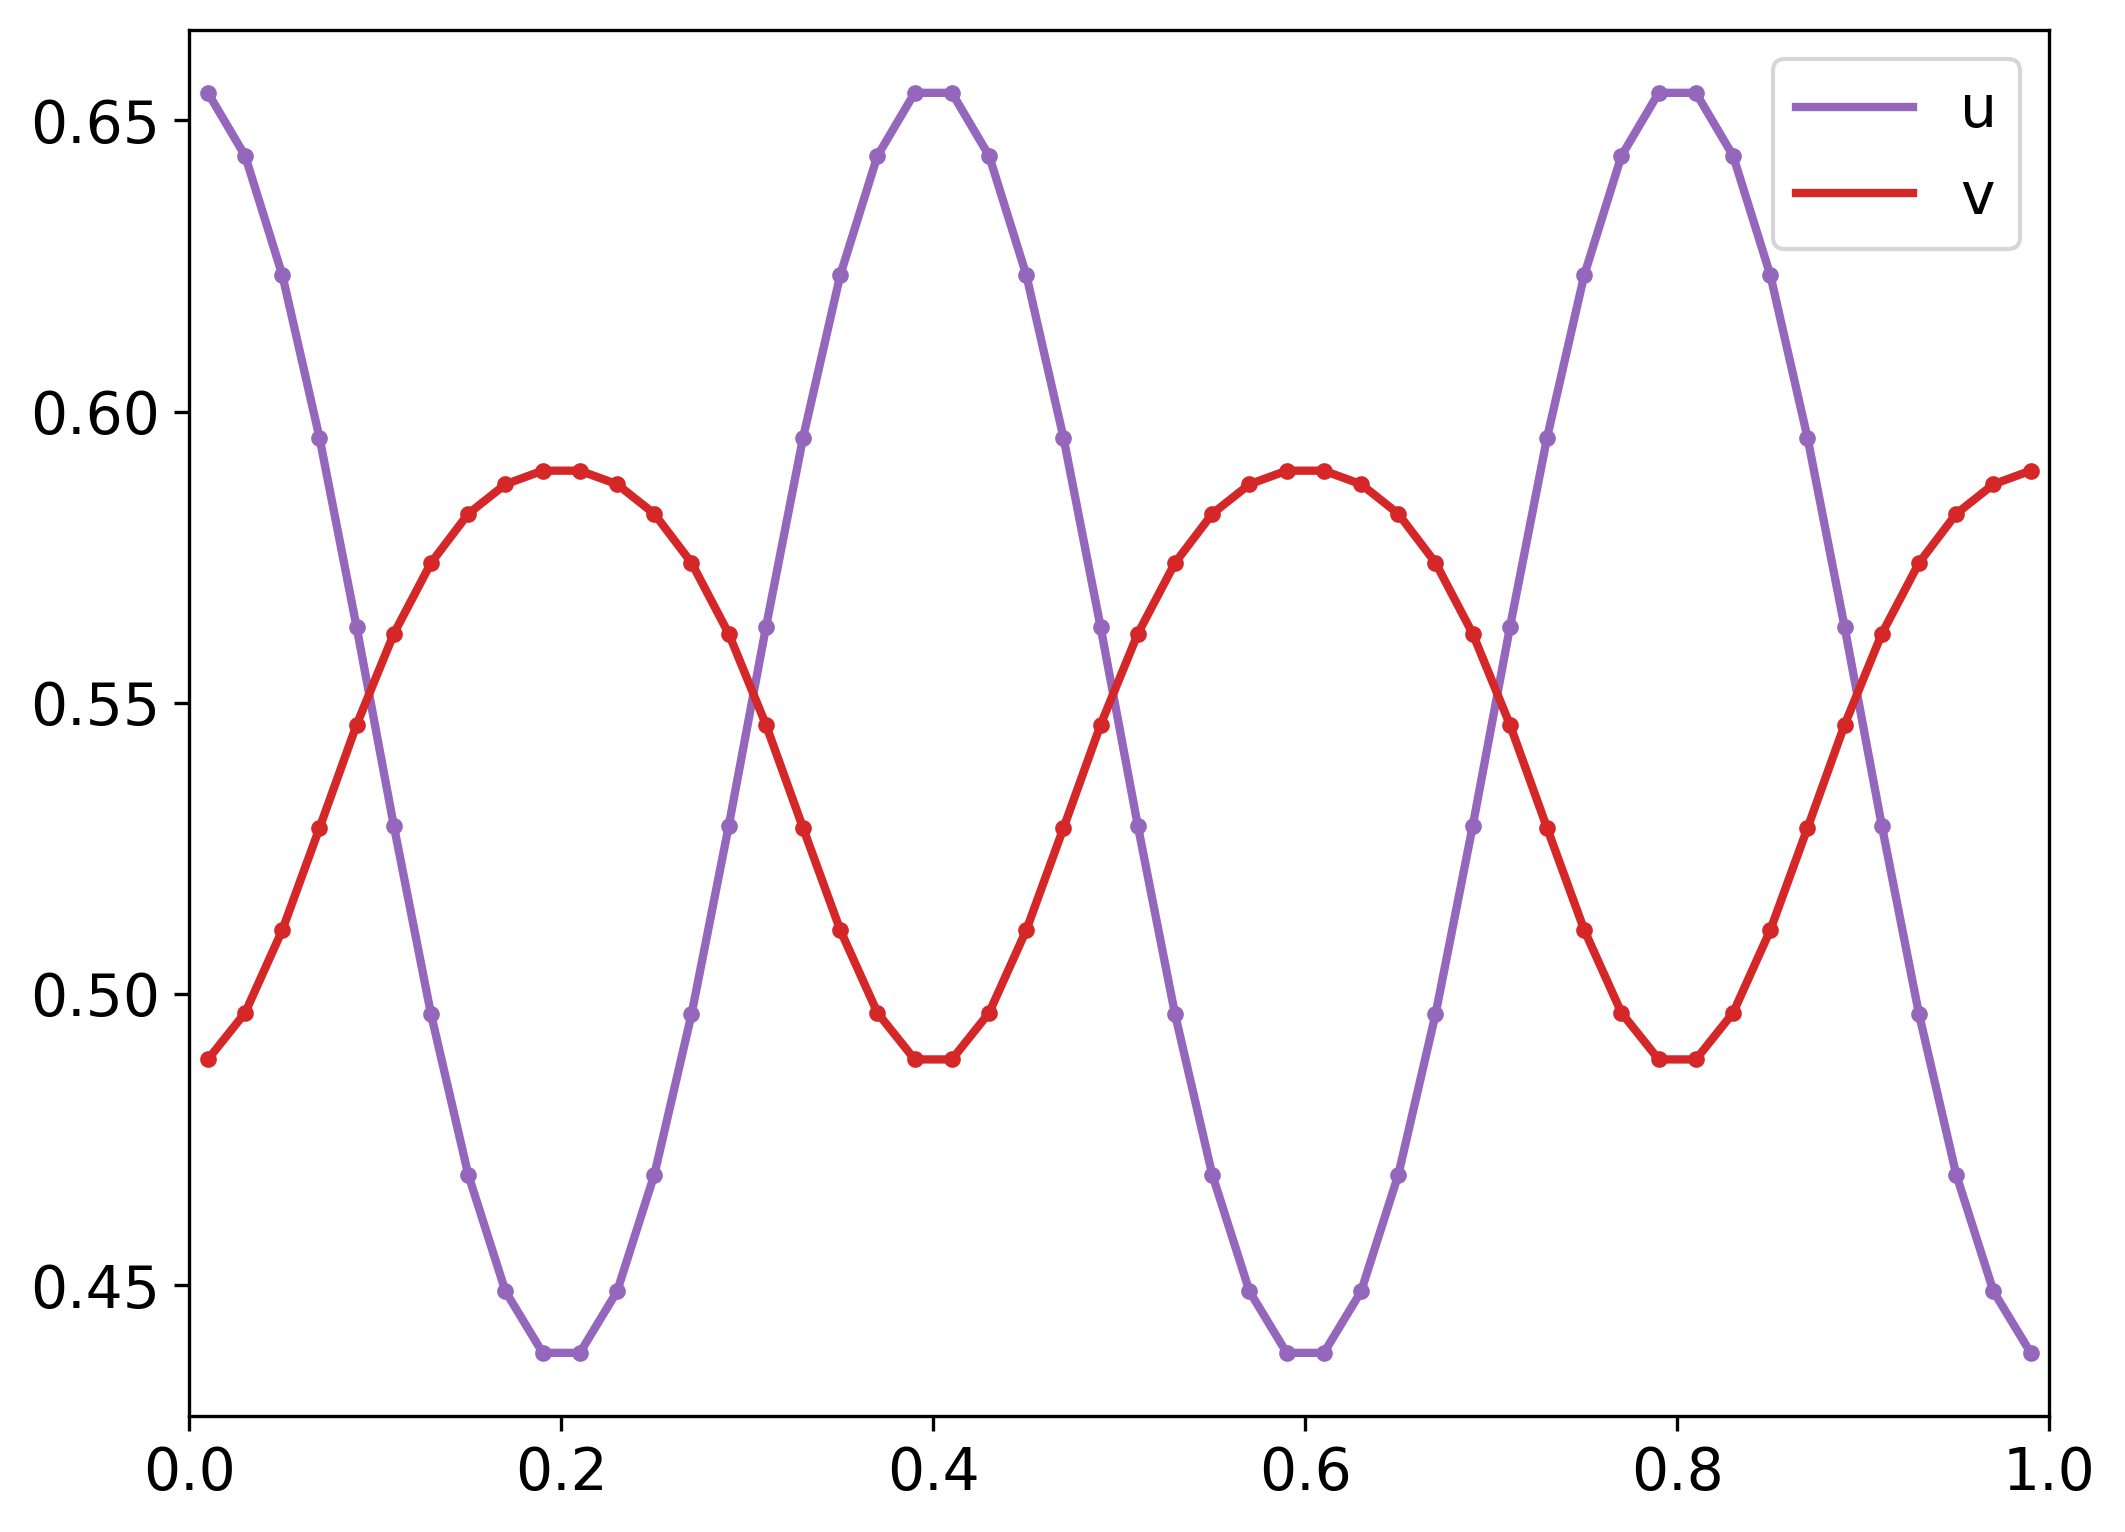

In [21]:
fig = plt.figure(figsize=(8,6),dpi=300)
axes = fig.add_subplot(1,1,1)
nx = 50
dx = 0.02
x = np.linspace(-0.5 * dx, dx * (nx + 0.5), nx + 2)[1:-1]
axes.plot(x, X[50, 0],label='u', c='tab:purple',linewidth=2)
axes.plot(x, X[50, 0],'o', markersize=3, c='tab:purple')
axes.plot(x, X[50, 1],label='v', c='tab:red',linewidth=2)
axes.plot(x, X[50, 1],'o', c='tab:red',markersize=3)
axes.set_xlim([0, 1.0])
axes.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('img/Predator_Prey.pdf')
plt.show()